### Импорт библиотек

In [1]:
import torch
import pandas as pd
import numpy as np
import pickle
from copy import deepcopy
import torch.nn as nn
import torchvision.models as models

from skimage import io
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from sklearn.metrics import f1_score

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import WeightedRandomSampler
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, Subset
from collections import Counter
from albumentations.pytorch.transforms import ToTensorV2
from albumentations import (
    Compose, OneOf, Resize, CenterCrop, RandomCrop, Rotate,
    HorizontalFlip, RandomBrightnessContrast, HueSaturationValue,
    CoarseDropout, Normalize, GaussNoise
)
import cv2
from multiprocessing import cpu_count
from termcolor import colored
from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [2]:
def set_seed(seed):
    global SEED
    SEED = seed

    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


###  Преобразование входных данных и настройка аугментации

In [5]:
RESCALE_SIZE = 224

# Определяем блок дополнительной аугментации, аналогичный RandomChoice
augmentation = OneOf([
    # Вариант 1: Resize до 300, затем CenterCrop и случайное обрезание до 250
    Compose([
        Resize(300 * 1.5, 300 * 1.5, interpolation=cv2.INTER_LINEAR, p=1.0),
        CenterCrop(300 * 1.5, 300 * 1.5, p=1.0),
        RandomCrop(250 * 1.5, 250 * 1.5, p=1.0)
    ], p=1.0),
    # Вариант 2: Случайное вращение в диапазоне (-25, 25) градусов
    Rotate(limit=25, border_mode=cv2.BORDER_REFLECT_101, p=1.0),
    # Вариант 3: Обязательный горизонтальный флип
    HorizontalFlip(p=1.0)
], p=1.0)

# Общий pipeline для обучения
train_transform = Compose([
    augmentation,
    Resize(RESCALE_SIZE, RESCALE_SIZE, interpolation=cv2.INTER_LINEAR, p=1.0),
    # Нормализация: albumentations ожидает входные значения в диапазоне 0-255
    Normalize(mean=(0.485, 0.456, 0.406), 
              std=(0.229, 0.224, 0.225), 
              max_pixel_value=255.0, p=1.0),
    ToTensorV2()
])

val_transform = Compose([
    Resize(RESCALE_SIZE, RESCALE_SIZE),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

test_transform = Compose([
    HorizontalFlip(p=1.0),
    Resize(RESCALE_SIZE, RESCALE_SIZE, interpolation=cv2.INTER_LINEAR, p=1.0),
    # Нормализация: albumentations ожидает входные значения в диапазоне 0-255
    Normalize(mean=(0.485, 0.456, 0.406), 
              std=(0.229, 0.224, 0.225), 
              max_pixel_value=255.0, p=1.0),
    ToTensorV2()
])

In [6]:
def multi_aug_transform(img, n=1):
    """
    Преобразует PIL.Image в массив и возвращает:
      - original: изображение, обработанное по val_transform,
      - aug_stack: тензор из n аугментированных изображений (train_transform)
    """
    img_np = np.array(img)
    original = val_transform(image=img_np)["image"]
    # Создаем список из n аугментированных изображений
    augmented_list = [train_transform(image=img_np)["image"] for _ in range(n)]
    # Склеиваем в один тензор размером (n, C, H, W)
    aug_stack = torch.stack(augmented_list)
    return original, aug_stack

def multi_aug_transform_test(img, n=1):
    """
    Преобразует PIL.Image в массив и возвращает:
      - original: изображение, обработанное по val_transform,
      - aug_stack: тензор из n аугментированных изображений (train_transform)
    """
    img_np = np.array(img)
    original = val_transform(image=img_np)["image"]
    # Создаем список из n аугментированных изображений
    augmented_list = [test_transform(image=img_np)["image"] for _ in range(n)]
    # Склеиваем в один тензор размером (n, C, H, W)
    aug_stack = torch.stack(augmented_list)
    return original, aug_stack

### Загрузка данных

In [7]:
# Датасеты
dataset = ImageFolder('data/train/simpsons_dataset', 
                      transform=multi_aug_transform)

labels = [sample[1] for sample in dataset.samples]

train_idx, val_idx = train_test_split(
    list(range(len(dataset))),
    test_size=0.003,
    stratify=labels,
    random_state=SEED
)

# Формируем списки образцов и меток для каждого датасета
train_samples = [dataset.samples[i] for i in train_idx]
train_targets = [dataset.targets[i] for i in train_idx]
val_samples = [dataset.samples[i] for i in val_idx]
val_targets = [dataset.targets[i] for i in val_idx]

# Создаем два отдельных экземпляра датасета с одинаковыми корневыми данными и преобразованиями
train_dataset = ImageFolder('data/train/simpsons_dataset', transform=multi_aug_transform)
val_dataset = ImageFolder('data/train/simpsons_dataset', transform=lambda img: val_transform(image=np.array(img))["image"])

# Переопределяем выборки и метки в каждом датасете
train_dataset.samples = train_samples
train_dataset.targets = train_targets

val_dataset.samples = val_samples
val_dataset.targets = val_targets

test_dataset = ImageFolder('data/testset/', 
                           transform=multi_aug_transform_test)#lambda img: val_transform(image=np.array(img))["image"]

In [8]:
# Статистика по классам
class_counts = np.bincount([sample[1] for sample in train_dataset.samples])
print(f"Class distribution: {[round(c / sum(class_counts) * 100, 2) for c in class_counts]}%")

Class distribution: [4.36, 0.2, 2.98, 0.51, 6.41, 0.47, 5.7, 4.71, 0.23, 2.24, 0.04, 2.18, 0.13, 0.13, 0.58, 10.73, 2.38, 5.76, 1.48, 0.01, 6.47, 0.61, 6.17, 0.34, 1.17, 5.16, 0.08, 6.94, 6.95, 1.71, 0.15, 0.34, 5.7, 0.31, 0.22, 0.43, 0.49, 4.19, 0.19, 0.26, 0.04, 0.86]%


<BarContainer object of 42 artists>

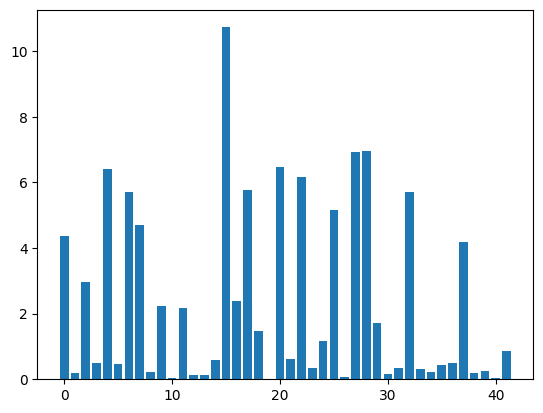

In [9]:
plt.bar(x=range(42), height=[round(c / sum(class_counts) * 100, 2) for c in class_counts])

### Обработка дисбаланса классов в данных

In [10]:
# взвешивание классов и нормализация
from torch import batch_norm


class_counts = np.bincount([sample[1] for sample in train_dataset.samples])
class_weights = 1.0 / class_counts
class_weights /= class_weights.sum()  # Нормализация

# присвоение изображению веса на основе его класса
sample_weights = np.array([class_weights[label] for _, label in train_dataset.samples], dtype=np.float32)

# статистика о семплировании
print(f"Sample weights (min, max): {sample_weights.min(), sample_weights.max()}")
print(f"Class weights (min, max): {class_weights.min(), class_weights.max()}")

# выборка с учётом весов
train_sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

batch_size = 32
accumulation_steps = 1024 // batch_size
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, shuffle=False, pin_memory=True, num_workers=min(8, cpu_count()))
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=min(8, cpu_count()))

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=min(8, cpu_count()))

Sample weights (min, max): (0.00045001172, 0.33585876)
Class weights (min, max): (0.00045001173513922033, 0.33585875832557144)


### Реализация модели

In [11]:
# class Net(nn.Module):
#     def __init__(self, num_classes=42):
#         super(Net, self).__init__()
#         self.resnet = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V1)

#         # Замораживание весов
#         for param in self.resnet.parameters():
#             param.requires_grad = False
        
#         in_features = self.resnet.fc.in_features
#         self.resnet.fc = nn.Sequential(
#             nn.Linear(in_features, 512),
#             nn.BatchNorm1d(512),
#             nn.ReLU(),

#             nn.Linear(512, num_classes),
#         )

#         # разморозим параметры последнего блока layer4 и полносвязного слоя
#         for param in self.resnet.layer3.parameters():
#             param.requires_grad = True
#         for param in self.resnet.layer4.parameters():
#             param.requires_grad = True
#         for param in self.resnet.fc.parameters():
#             param.requires_grad = True

#     def forward(self, x):
#         return self.resnet(x)

In [12]:
# class Net(nn.Module):
#     def __init__(self, num_classes=42):
#         super(Net, self).__init__()
#         # Загружаем предобученную модель DenseNet201
#         self.densenet = models.densenet201(weights=models.DenseNet201_Weights.IMAGENET1K_V1)
        
#         # Замораживаем все параметры
#         for param in self.densenet.parameters():
#             param.requires_grad = False
        
#         # Получаем число входных признаков классификатора
#         in_features = self.densenet.classifier.in_features
        
#         # Заменяем классификатор на новый блок
#         # Здесь: сначала линейный слой расширяет размерность в 4 раза,
#         # затем BatchNorm, ReLU, MaxPool1d (уменьшает размерность вдвое),
#         # затем второй линейный слой, BatchNorm, ReLU и финальный линейный слой,
#         # выдающий num_classes выходов.
#         self.densenet.classifier = nn.Sequential(
#             nn.Linear(in_features, in_features * 4),
#             nn.BatchNorm1d(in_features * 4),
#             nn.ReLU(),
#             nn.MaxPool1d(kernel_size=2),  # После этого размерность станет in_features*2

#             nn.Linear(in_features * 2, in_features),
#             nn.BatchNorm1d(in_features),
#             nn.ReLU(),

#             nn.Linear(in_features, num_classes),
#         )
        
#         # Разморозим параметры последнего блока признаков (denseblock4) и классификатора
#         for param in self.densenet.features.denseblock4.parameters():
#             param.requires_grad = True
#         for param in self.densenet.classifier.parameters():
#             param.requires_grad = True

#     def forward(self, x):
#         return self.densenet(x)

In [13]:
# class Net(nn.Module):
#     def __init__(self, num_classes=42):
#         super(Net, self).__init__()
#         # Загружаем предобученную модель ViT128
#         for param in self.vit.parameters():
#             param.requires_grad = True#False

#         # Разморозим параметры последнего блока энкодера
#         for param in self.vit.encoder.layers[-1].parameters():
#             param.requires_grad = True

#         # Разморозим параметры классификатора (heads)
#         # Если heads является nn.Sequential, то заменим последний слой
#         if isinstance(self.vit.heads, nn.Sequential):
#             # Предполагаем, что последний слой — это Linear
#             in_features = self.vit.heads[-1].in_features
#             self.vit.heads[-1] = nn.Linear(in_features, num_classes)
#         else:
#             # Если heads не является последовательностью
#             in_features = self.vit.heads.in_features
#             self.vit.heads = nn.Linear(in_features, num_classes)

#         # Если требуется разморозить параметры нового классификатора:
#         for param in self.vit.heads.parameters():
#             param.requires_grad = True

#     def forward(self, x):
#         return self.vit(x)

In [14]:
class ResBlock(nn.Module):
    def __init__(self, n_channels, kernel_size, p):
        super(ResBlock, self).__init__()
        assert kernel_size % 2 == 1
        self.convs = nn.Sequential(
            nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding=kernel_size // 2),
            # nn.BatchNorm2d(num_features=n_channels),
            nn.ReLU(),
            nn.Dropout2d(p=p),

            nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.BatchNorm2d(num_features=n_channels),
        )
        self.merge = nn.Sequential(
            nn.BatchNorm2d(num_features=n_channels),
            nn.ReLU(),
        )
    
    def forward(self, x):
        x_ = x
        x = self.convs(x)
        x += x_
        x = self.merge(x)
        return x

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, conv_kernel_size, pool_kernel_size, p):
        super(ConvBlock, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=conv_kernel_size, padding=conv_kernel_size // 2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel_size),
            nn.Dropout2d(p=p),
        )
    
    def forward(self, x):
        x = self.layer(x)
        return x

class Net(nn.Module):
    def __init__(self, num_classes=42):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            ConvBlock(in_channels=3, out_channels=16, 
                      conv_kernel_size=7, pool_kernel_size=2, p=0.0),

            ResBlock(n_channels=16, kernel_size=3, p=0.0),
            ResBlock(n_channels=16, kernel_size=3, p=0.0),

            ConvBlock(in_channels=16, out_channels=32, 
                      conv_kernel_size=3, pool_kernel_size=2, p=0.0),

            ResBlock(n_channels=32, kernel_size=3, p=0.0),
            ResBlock(n_channels=32, kernel_size=3, p=0.0),

            ConvBlock(in_channels=32, out_channels=64, 
                      conv_kernel_size=3, pool_kernel_size=2, p=0.0),

            ResBlock(n_channels=64, kernel_size=3, p=0.0),
            ResBlock(n_channels=64, kernel_size=3, p=0.0),

            ConvBlock(in_channels=64, out_channels=128, 
                      conv_kernel_size=3, pool_kernel_size=2, p=0.0),
            ConvBlock(in_channels=128, out_channels=256, 
                      conv_kernel_size=3, pool_kernel_size=2, p=0.0),
            ConvBlock(in_channels=256, out_channels=512, 
                      conv_kernel_size=3, pool_kernel_size=2, p=0.0),
            ConvBlock(in_channels=512, out_channels=1024, 
                      conv_kernel_size=3, pool_kernel_size=2, p=0.0),
        )

        self.globavgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc = nn.Sequential(
            nn.Linear(in_features=1024 * 1 * 1, out_features=2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),

            nn.Dropout(p=0.4),

            nn.Linear(in_features=2048, out_features=1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),

            nn.Dropout(p=0.0),
        )

        self.out = nn.Sequential(
            nn.Linear(in_features=1024, out_features=num_classes),
        )
        
    def forward(self, x):
        x = self.conv(x)

        x = self.globavgpool(x)
        x = torch.flatten(x, 1)

        x = self.fc(x)
        x = self.out(x)

        return x

### Обучение модели и предсказание на тестовом наборе данных

In [15]:
def load_checkpoint(filepath, model, optimizer=None, scheduler=None):
    checkpoint = torch.load(filepath)
    
    # Загрузка состояния модели
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Если требуется, загружаем состояние оптимизатора
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    # Если используется scheduler и он сохранён в чекпоинте, загружаем его состояние
    if scheduler is not None and checkpoint.get('scheduler_state_dict') is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    
    epoch = checkpoint.get('epoch', None)
    train_loss = checkpoint.get('train_loss', None)
    val_loss = checkpoint.get('val_loss', None)
    
    print(f"Checkpoint loaded: Epoch {epoch}; Train loss: {train_loss}; Val loss: {val_loss}")
    
    return model, optimizer, scheduler, epoch, train_loss, val_loss

In [16]:
def training_epoch(model, optimizer, criterion, train_loader, epoch, accumulation_steps):
    train_loss = 0.0
    train_accuracy = 0.0
    all_train_preds = []
    all_train_targets = []
    model.train()

    n_samples = 0
    pb = tqdm(enumerate(train_loader), total=len(train_loader))
    loss_hist, accuracy_hist = [], []
    
    optimizer.zero_grad()
    
    for batch_idx, ((orig_imgs, aug_imgs), labels) in pb:
        # orig_imgs: (B, C, H, W)
        # aug_imgs: (B, n, C, H, W) – n аугментированных изображений для каждого примера
        orig_imgs = orig_imgs.to(device)
        aug_imgs = aug_imgs.to(device)  # shape: (B, n, C, H, W)
        labels = labels.to(device)
        
        # Прямой проход для оригинальных изображений
        logits_orig = model(orig_imgs)  # (B, num_classes)
        
        # Для аугментированных изображений: объединяем батч и n
        B, n, C, H, W = aug_imgs.shape
        aug_imgs_flat = aug_imgs.view(B * n, C, H, W)  # (B*n, C, H, W)
        logits_aug_all = model(aug_imgs_flat)  # (B*n, num_classes)
        # Восстанавливаем размерность и усредняем по n
        logits_aug_all = logits_aug_all.view(B, n, -1)  # (B, n, num_classes)
        logits_aug_avg = logits_aug_all.mean(dim=1)      # (B, num_classes)
        
        # Вычисляем потери для оригинала и усредненного аугмента, затем усредняем
        loss_orig = criterion(logits_orig, labels)
        loss_aug = criterion(logits_aug_avg, labels)
        loss = (loss_orig + loss_aug) / 2
        
        # Scale loss for gradient accumulation
        loss = loss / accumulation_steps
        loss.backward()
        
        # Accumulate gradients: update when we have processed accumulation_steps mini-batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader):
            optimizer.step()
            optimizer.zero_grad()
        
        train_loss += loss.item() * labels.size(0)
        n_samples += labels.size(0)
        
        # Предсказания для оригинала
        preds_orig = logits_orig.argmax(dim=1)
        # Предсказания для аугментированных (усредненные)
        preds_aug = logits_aug_avg.argmax(dim=1)
        
        # Считаем корректные предсказания и усредняем
        correct_orig = (preds_orig == labels).sum().item()
        correct_aug = (preds_aug == labels).sum().item()
        train_accuracy += (correct_orig + correct_aug) / 2

        pb.set_description(f'Training:      loss = [' + colored(f'{(train_loss / n_samples):.4f}', 'green') + '];    accuracy = [' + colored(f'{(train_accuracy / n_samples):.4f}', 'green') + ']')
        loss_hist.append(loss.item())#train_loss / n_samples
        accuracy_hist.append(((correct_orig + correct_aug) / 2) / labels.size(0))#train_accuracy / n_samples

        # Для метрики F1 используем предсказания оригинала
        all_train_preds.extend(preds_orig.cpu().numpy())
        all_train_targets.extend(labels.cpu().numpy())

    np.array(loss_hist).dump(f'logs/train_loss_hist_epoch_{epoch}.npy')
    print(f'[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_{epoch}.npy]')
    np.array(accuracy_hist).dump(f'logs/train_accuracy_hist_epoch_{epoch}.npy')
    print(f'[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_{epoch}.npy]')

    n_samples = len(train_loader.dataset)
    avg_loss = train_loss / n_samples
    avg_acc = train_accuracy / n_samples
    avg_f1 = f1_score(all_train_targets, all_train_preds, average='micro')
    return avg_loss, avg_acc, avg_f1

def validation_epoch(model, criterion, val_loader):
    model.eval()
    val_loss = 0.0
    val_accuracy = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        n_samples = 0
        pb = tqdm(val_loader)

        # Валидационный датасет возвращает (image, label)
        for images, labels in pb:
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            loss = criterion(logits, labels)
            val_loss += loss.item() * labels.size(0)
            n_samples += labels.size(0)

            preds = logits.argmax(dim=1)
            correct = (preds == labels).sum().item()
            val_accuracy += correct

            pb.set_description(f'Validation:    loss = [' + colored(f'{(val_loss / n_samples):.4f}', 'green') + '];    accuracy = [' + colored(f'{(val_accuracy / n_samples):.4f}', 'green') + ']')

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
    
    n_samples = len(val_loader.dataset)
    avg_loss = val_loss / n_samples
    avg_acc = val_accuracy / n_samples
    # Вычисляем макро F1 score
    avg_f1 = f1_score(all_targets, all_preds, average='micro')
    return avg_loss, avg_acc, avg_f1

def train(model, optimizer, criterion, train_loader, val_loader, accumulation_steps, num_epochs, init_epoch=1, save_period=4, scheduler=None):
    best_model = None
    best_val_loss = 1e+9
    
    for epoch in range(init_epoch, num_epochs + 1):
        print(f'Epoch {epoch}/{num_epochs}:')
        print(f'lr = {scheduler.get_last_lr()}')

        train_loss, train_acc, train_f1 = training_epoch(
            model, optimizer, criterion, train_loader, epoch, accumulation_steps
        )
        val_loss, val_acc, val_f1 = validation_epoch(
            model, criterion, val_loader
        )
        
        if scheduler is not None:
            scheduler.step()
        
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}')
        print(f'  Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}, Val   F1: {val_f1:.4f}')
        
        # Сохраняем лучшую модель по валидации
        if val_loss <= best_val_loss:
            best_model = deepcopy(model)
            best_val_loss = val_loss

        # Бэкап модели на каждую эпоху
        if epoch % save_period == 0:
            backup_filename = f'checkpoints/model_epoch_{epoch}.pth'
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None,
                'train_loss': train_loss,
                'val_loss': val_loss
            }, backup_filename)
            print(f'[BACKUP] Backup saved in [{backup_filename}]')

        print()
            
    return best_model

@torch.no_grad()
def predict(model, test_loader):
    all_preds = []
    all_labels = []
    model.eval()
    for (orig_imgs, aug_imgs), labels in tqdm(test_loader, desc="Predicting"):
        # orig_imgs: (B, C, H, W)
        # aug_imgs: (B, n, C, H, W) – n аугментированных изображений для каждого примера
        orig_imgs = orig_imgs.to(device)
        aug_imgs = aug_imgs.to(device)  # shape: (B, n, C, H, W)
        
        # Прямой проход для оригинальных изображений
        logits_orig = model(orig_imgs)
        B, n, C, H, W = aug_imgs.shape
        aug_imgs_flat = aug_imgs.view(B * n, C, H, W)  # (B*n, C, H, W)
        logits_aug_all = model(aug_imgs_flat)  # (B*n, num_classes)
        # Восстанавливаем размерность и усредняем по n
        logits_aug_all = logits_aug_all.view(B, n, -1)  # (B, n, num_classes)
        logits_aug_avg = logits_aug_all.mean(dim=1)      # (B, num_classes)
        outputs = (logits_orig * 0.5 + logits_aug_avg * 0.5) / (0.5 + 0.5)


        # images = images.to(device)
        # outputs = model(images)
        all_preds.append(outputs.argmax(dim=1).cpu().numpy())
        all_labels.append(labels.numpy())
    
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return all_preds, all_labels

In [17]:
model = Net(num_classes=len(train_dataset.classes)).to(device)
model

Net(
  (conv): Sequential(
    (0): ConvBlock(
      (layer): Sequential(
        (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (4): Dropout2d(p=0.0, inplace=False)
      )
    )
    (1): ResBlock(
      (convs): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Dropout2d(p=0.0, inplace=False)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (merge): Sequential(
        (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
      )
    )
    (2): ResBlock(
      (convs): Sequential(
        (0): Conv2

In [18]:
print(f'{np.sum([p.numel() for p in model.parameters()]):,} parameters')

10,739,818 parameters


In [19]:
num_epochs = 56
init_epoch = 1
save_period = 4
lr1 = 1e-3
lr2 = 1e-3 * (1e-3 ** (7 / 8))#1e-6
step_size = 4

criterion = torch.nn.CrossEntropyLoss()

model = nn.DataParallel(model)
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr1, amsgrad=True)#torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=4e-3)
# T_max = num_epochs // 2
gamma = (lr2 / lr1) ** (1 / (num_epochs // step_size))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)#torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)
print(f'gamma set to {gamma}')
print(f'gradient accumulation steps set to {accumulation_steps}')

gamma set to 0.6493816315762113
gradient accumulation steps set to 32


In [20]:
1e-3 * (1e-3 ** (7 / 8))

2.3713737056616556e-06

In [21]:
if init_epoch > 1:
    checkpoint_path = f'checkpoints/model_epoch_{init_epoch - 1}.pth'
    model, optimizer, scheduler, epoch, train_loss, val_loss = load_checkpoint(
        checkpoint_path, model, optimizer, scheduler
    )

In [22]:
# train gives best model but I'll use usual model later
best_model = train(model, optimizer, criterion, train_dataloader, val_dataloader, accumulation_steps, num_epochs, init_epoch, save_period, scheduler)

Epoch 1/56:
lr = [0.001]


Training:      loss = [0.0849];    accuracy = [0.2943]: 100%|██████████| 653/653 [00:49<00:00, 13.21it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_1.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_1.npy]


Validation:    loss = [2.2199];    accuracy = [0.3810]: 100%|██████████| 2/2 [00:00<00:00,  4.65it/s]

  Train Loss: 0.0849, Train Acc: 0.2943, Train F1: 0.3123
  Val   Loss: 2.2199, Val   Acc: 0.3810, Val   F1: 0.3810

Epoch 2/56:
lr = [0.001]



Training:      loss = [0.0412];    accuracy = [0.6501]: 100%|██████████| 653/653 [00:49<00:00, 13.09it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_2.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_2.npy]


Validation:    loss = [1.3975];    accuracy = [0.5238]: 100%|██████████| 2/2 [00:00<00:00,  4.60it/s]

  Train Loss: 0.0412, Train Acc: 0.6501, Train F1: 0.6806
  Val   Loss: 1.3975, Val   Acc: 0.5238, Val   F1: 0.5238

Epoch 3/56:
lr = [0.001]



Training:      loss = [0.0228];    accuracy = [0.8005]: 100%|██████████| 653/653 [00:51<00:00, 12.68it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_3.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_3.npy]


Validation:    loss = [0.9218];    accuracy = [0.7302]: 100%|██████████| 2/2 [00:00<00:00,  4.91it/s]

  Train Loss: 0.0228, Train Acc: 0.8005, Train F1: 0.8264
  Val   Loss: 0.9218, Val   Acc: 0.7302, Val   F1: 0.7302

Epoch 4/56:
lr = [0.001]



Training:      loss = [0.0145];    accuracy = [0.8723]: 100%|██████████| 653/653 [00:51<00:00, 12.60it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_4.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_4.npy]


Validation:    loss = [0.5687];    accuracy = [0.7937]: 100%|██████████| 2/2 [00:00<00:00,  4.18it/s]


  Train Loss: 0.0145, Train Acc: 0.8723, Train F1: 0.8975
  Val   Loss: 0.5687, Val   Acc: 0.7937, Val   F1: 0.7937
[BACKUP] Backup saved in [checkpoints/model_epoch_4.pth]

Epoch 5/56:
lr = [0.0006493816315762113]


Training:      loss = [0.0100];    accuracy = [0.9135]: 100%|██████████| 653/653 [00:49<00:00, 13.13it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_5.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_5.npy]


Validation:    loss = [0.3784];    accuracy = [0.8730]: 100%|██████████| 2/2 [00:00<00:00,  4.12it/s]

  Train Loss: 0.0100, Train Acc: 0.9135, Train F1: 0.9329
  Val   Loss: 0.3784, Val   Acc: 0.8730, Val   F1: 0.8730

Epoch 6/56:
lr = [0.0006493816315762113]



Training:      loss = [0.0073];    accuracy = [0.9379]: 100%|██████████| 653/653 [00:49<00:00, 13.20it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_6.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_6.npy]


Validation:    loss = [0.1401];    accuracy = [0.9683]: 100%|██████████| 2/2 [00:00<00:00,  4.11it/s]

  Train Loss: 0.0073, Train Acc: 0.9379, Train F1: 0.9537
  Val   Loss: 0.1401, Val   Acc: 0.9683, Val   F1: 0.9683

Epoch 7/56:
lr = [0.0006493816315762113]



Training:      loss = [0.0060];    accuracy = [0.9474]: 100%|██████████| 653/653 [00:49<00:00, 13.32it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_7.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_7.npy]


Validation:    loss = [0.2654];    accuracy = [0.8730]: 100%|██████████| 2/2 [00:00<00:00,  4.32it/s]

  Train Loss: 0.0060, Train Acc: 0.9474, Train F1: 0.9622
  Val   Loss: 0.2654, Val   Acc: 0.8730, Val   F1: 0.8730

Epoch 8/56:
lr = [0.0006493816315762113]



Training:      loss = [0.0055];    accuracy = [0.9518]: 100%|██████████| 653/653 [00:49<00:00, 13.28it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_8.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_8.npy]


Validation:    loss = [0.1443];    accuracy = [0.9524]: 100%|██████████| 2/2 [00:00<00:00,  4.66it/s]


  Train Loss: 0.0055, Train Acc: 0.9518, Train F1: 0.9672
  Val   Loss: 0.1443, Val   Acc: 0.9524, Val   F1: 0.9524
[BACKUP] Backup saved in [checkpoints/model_epoch_8.pth]

Epoch 9/56:
lr = [0.0004216965034285823]


Training:      loss = [0.0045];    accuracy = [0.9609]: 100%|██████████| 653/653 [00:49<00:00, 13.20it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_9.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_9.npy]


Validation:    loss = [0.2070];    accuracy = [0.9524]: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

  Train Loss: 0.0045, Train Acc: 0.9609, Train F1: 0.9750
  Val   Loss: 0.2070, Val   Acc: 0.9524, Val   F1: 0.9524

Epoch 10/56:
lr = [0.0004216965034285823]



Training:      loss = [0.0035];    accuracy = [0.9695]: 100%|██████████| 653/653 [00:47<00:00, 13.65it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_10.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_10.npy]


Validation:    loss = [0.1603];    accuracy = [0.9365]: 100%|██████████| 2/2 [00:00<00:00,  7.15it/s]

  Train Loss: 0.0035, Train Acc: 0.9695, Train F1: 0.9806
  Val   Loss: 0.1603, Val   Acc: 0.9365, Val   F1: 0.9365

Epoch 11/56:
lr = [0.0004216965034285823]



Training:      loss = [0.0031];    accuracy = [0.9739]: 100%|██████████| 653/653 [00:47<00:00, 13.62it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_11.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_11.npy]


Validation:    loss = [0.0541];    accuracy = [0.9841]: 100%|██████████| 2/2 [00:00<00:00,  4.59it/s]

  Train Loss: 0.0031, Train Acc: 0.9739, Train F1: 0.9833
  Val   Loss: 0.0541, Val   Acc: 0.9841, Val   F1: 0.9841

Epoch 12/56:
lr = [0.0004216965034285823]



Training:      loss = [0.0027];    accuracy = [0.9772]: 100%|██████████| 653/653 [00:48<00:00, 13.44it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_12.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_12.npy]


Validation:    loss = [0.1438];    accuracy = [0.9524]: 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]


  Train Loss: 0.0027, Train Acc: 0.9772, Train F1: 0.9872
  Val   Loss: 0.1438, Val   Acc: 0.9524, Val   F1: 0.9524
[BACKUP] Backup saved in [checkpoints/model_epoch_12.pth]

Epoch 13/56:
lr = [0.00027384196342643616]


Training:      loss = [0.0024];    accuracy = [0.9801]: 100%|██████████| 653/653 [00:47<00:00, 13.71it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_13.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_13.npy]


Validation:    loss = [0.0615];    accuracy = [0.9841]: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]

  Train Loss: 0.0024, Train Acc: 0.9801, Train F1: 0.9895
  Val   Loss: 0.0615, Val   Acc: 0.9841, Val   F1: 0.9841

Epoch 14/56:
lr = [0.00027384196342643616]



Training:      loss = [0.0022];    accuracy = [0.9825]: 100%|██████████| 653/653 [00:47<00:00, 13.71it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_14.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_14.npy]


Validation:    loss = [0.1029];    accuracy = [0.9524]: 100%|██████████| 2/2 [00:00<00:00,  6.70it/s]

  Train Loss: 0.0022, Train Acc: 0.9825, Train F1: 0.9910
  Val   Loss: 0.1029, Val   Acc: 0.9524, Val   F1: 0.9524

Epoch 15/56:
lr = [0.00027384196342643616]



Training:      loss = [0.0018];    accuracy = [0.9856]: 100%|██████████| 653/653 [00:48<00:00, 13.58it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_15.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_15.npy]


Validation:    loss = [0.0988];    accuracy = [0.9683]: 100%|██████████| 2/2 [00:00<00:00,  6.76it/s]

  Train Loss: 0.0018, Train Acc: 0.9856, Train F1: 0.9936
  Val   Loss: 0.0988, Val   Acc: 0.9683, Val   F1: 0.9683

Epoch 16/56:
lr = [0.00027384196342643616]



Training:      loss = [0.0015];    accuracy = [0.9879]: 100%|██████████| 653/653 [00:47<00:00, 13.65it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_16.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_16.npy]


Validation:    loss = [0.1274];    accuracy = [0.9841]: 100%|██████████| 2/2 [00:00<00:00,  3.77it/s]


  Train Loss: 0.0015, Train Acc: 0.9879, Train F1: 0.9947
  Val   Loss: 0.1274, Val   Acc: 0.9841, Val   F1: 0.9841
[BACKUP] Backup saved in [checkpoints/model_epoch_16.pth]

Epoch 17/56:
lr = [0.0001778279410038923]


Training:      loss = [0.0015];    accuracy = [0.9879]: 100%|██████████| 653/653 [00:47<00:00, 13.62it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_17.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_17.npy]


Validation:    loss = [0.0873];    accuracy = [0.9841]: 100%|██████████| 2/2 [00:00<00:00,  4.43it/s]

  Train Loss: 0.0015, Train Acc: 0.9879, Train F1: 0.9946
  Val   Loss: 0.0873, Val   Acc: 0.9841, Val   F1: 0.9841

Epoch 18/56:
lr = [0.0001778279410038923]



Training:      loss = [0.0012];    accuracy = [0.9905]: 100%|██████████| 653/653 [00:47<00:00, 13.64it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_18.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_18.npy]


Validation:    loss = [0.0682];    accuracy = [0.9841]: 100%|██████████| 2/2 [00:00<00:00,  3.88it/s]

  Train Loss: 0.0012, Train Acc: 0.9905, Train F1: 0.9966
  Val   Loss: 0.0682, Val   Acc: 0.9841, Val   F1: 0.9841

Epoch 19/56:
lr = [0.0001778279410038923]



Training:      loss = [0.0013];    accuracy = [0.9901]: 100%|██████████| 653/653 [00:47<00:00, 13.63it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_19.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_19.npy]


Validation:    loss = [0.0539];    accuracy = [0.9841]: 100%|██████████| 2/2 [00:00<00:00,  4.11it/s]

  Train Loss: 0.0013, Train Acc: 0.9901, Train F1: 0.9959
  Val   Loss: 0.0539, Val   Acc: 0.9841, Val   F1: 0.9841

Epoch 20/56:
lr = [0.0001778279410038923]



Training:      loss = [0.0010];    accuracy = [0.9918]: 100%|██████████| 653/653 [00:50<00:00, 12.90it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_20.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_20.npy]


Validation:    loss = [0.0775];    accuracy = [0.9841]: 100%|██████████| 2/2 [00:00<00:00,  4.68it/s]


  Train Loss: 0.0010, Train Acc: 0.9918, Train F1: 0.9970
  Val   Loss: 0.0775, Val   Acc: 0.9841, Val   F1: 0.9841
[BACKUP] Backup saved in [checkpoints/model_epoch_20.pth]

Epoch 21/56:
lr = [0.00011547819846894584]


Training:      loss = [0.0010];    accuracy = [0.9923]: 100%|██████████| 653/653 [00:51<00:00, 12.78it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_21.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_21.npy]


Validation:    loss = [0.0630];    accuracy = [0.9841]: 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]

  Train Loss: 0.0010, Train Acc: 0.9923, Train F1: 0.9975
  Val   Loss: 0.0630, Val   Acc: 0.9841, Val   F1: 0.9841

Epoch 22/56:
lr = [0.00011547819846894584]



Training:      loss = [0.0009];    accuracy = [0.9935]: 100%|██████████| 653/653 [00:51<00:00, 12.61it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_22.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_22.npy]


Validation:    loss = [0.0702];    accuracy = [0.9841]: 100%|██████████| 2/2 [00:00<00:00,  3.78it/s]

  Train Loss: 0.0009, Train Acc: 0.9935, Train F1: 0.9979
  Val   Loss: 0.0702, Val   Acc: 0.9841, Val   F1: 0.9841

Epoch 23/56:
lr = [0.00011547819846894584]



Training:      loss = [0.0008];    accuracy = [0.9933]: 100%|██████████| 653/653 [00:51<00:00, 12.63it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_23.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_23.npy]


Validation:    loss = [0.0434];    accuracy = [0.9841]: 100%|██████████| 2/2 [00:00<00:00,  3.90it/s]

  Train Loss: 0.0008, Train Acc: 0.9933, Train F1: 0.9977
  Val   Loss: 0.0434, Val   Acc: 0.9841, Val   F1: 0.9841

Epoch 24/56:
lr = [0.00011547819846894584]



Training:      loss = [0.0008];    accuracy = [0.9939]: 100%|██████████| 653/653 [00:50<00:00, 12.81it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_24.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_24.npy]


Validation:    loss = [0.0473];    accuracy = [0.9841]: 100%|██████████| 2/2 [00:00<00:00,  4.43it/s]


  Train Loss: 0.0008, Train Acc: 0.9939, Train F1: 0.9983
  Val   Loss: 0.0473, Val   Acc: 0.9841, Val   F1: 0.9841
[BACKUP] Backup saved in [checkpoints/model_epoch_24.pth]

Epoch 25/56:
lr = [7.49894209332456e-05]


Training:      loss = [0.0008];    accuracy = [0.9936]: 100%|██████████| 653/653 [00:50<00:00, 12.80it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_25.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_25.npy]


Validation:    loss = [0.0571];    accuracy = [0.9683]: 100%|██████████| 2/2 [00:00<00:00,  3.87it/s]

  Train Loss: 0.0008, Train Acc: 0.9936, Train F1: 0.9979
  Val   Loss: 0.0571, Val   Acc: 0.9683, Val   F1: 0.9683

Epoch 26/56:
lr = [7.49894209332456e-05]



Training:      loss = [0.0008];    accuracy = [0.9939]: 100%|██████████| 653/653 [00:51<00:00, 12.71it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_26.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_26.npy]


Validation:    loss = [0.0328];    accuracy = [0.9841]: 100%|██████████| 2/2 [00:00<00:00,  5.07it/s]

  Train Loss: 0.0008, Train Acc: 0.9939, Train F1: 0.9980
  Val   Loss: 0.0328, Val   Acc: 0.9841, Val   F1: 0.9841

Epoch 27/56:
lr = [7.49894209332456e-05]



Training:      loss = [0.0007];    accuracy = [0.9947]: 100%|██████████| 653/653 [00:51<00:00, 12.74it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_27.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_27.npy]


Validation:    loss = [0.0709];    accuracy = [0.9683]: 100%|██████████| 2/2 [00:00<00:00,  4.75it/s]

  Train Loss: 0.0007, Train Acc: 0.9947, Train F1: 0.9988
  Val   Loss: 0.0709, Val   Acc: 0.9683, Val   F1: 0.9683

Epoch 28/56:
lr = [7.49894209332456e-05]



Training:      loss = [0.0007];    accuracy = [0.9948]: 100%|██████████| 653/653 [00:51<00:00, 12.70it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_28.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_28.npy]


Validation:    loss = [0.0621];    accuracy = [0.9841]: 100%|██████████| 2/2 [00:00<00:00,  5.75it/s]


  Train Loss: 0.0007, Train Acc: 0.9948, Train F1: 0.9986
  Val   Loss: 0.0621, Val   Acc: 0.9841, Val   F1: 0.9841
[BACKUP] Backup saved in [checkpoints/model_epoch_28.pth]

Epoch 29/56:
lr = [4.869675251658632e-05]


Training:      loss = [0.0007];    accuracy = [0.9948]: 100%|██████████| 653/653 [00:50<00:00, 12.81it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_29.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_29.npy]


Validation:    loss = [0.0619];    accuracy = [0.9683]: 100%|██████████| 2/2 [00:00<00:00,  7.10it/s]

  Train Loss: 0.0007, Train Acc: 0.9948, Train F1: 0.9988
  Val   Loss: 0.0619, Val   Acc: 0.9683, Val   F1: 0.9683

Epoch 30/56:
lr = [4.869675251658632e-05]



Training:      loss = [0.0006];    accuracy = [0.9954]: 100%|██████████| 653/653 [00:51<00:00, 12.80it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_30.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_30.npy]


Validation:    loss = [0.0687];    accuracy = [0.9683]: 100%|██████████| 2/2 [00:00<00:00,  3.92it/s]

  Train Loss: 0.0006, Train Acc: 0.9954, Train F1: 0.9993
  Val   Loss: 0.0687, Val   Acc: 0.9683, Val   F1: 0.9683

Epoch 31/56:
lr = [4.869675251658632e-05]



Training:      loss = [0.0006];    accuracy = [0.9957]: 100%|██████████| 653/653 [00:50<00:00, 12.83it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_31.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_31.npy]


Validation:    loss = [0.0501];    accuracy = [0.9683]: 100%|██████████| 2/2 [00:00<00:00,  4.15it/s]

  Train Loss: 0.0006, Train Acc: 0.9957, Train F1: 0.9992
  Val   Loss: 0.0501, Val   Acc: 0.9683, Val   F1: 0.9683

Epoch 32/56:
lr = [4.869675251658632e-05]



Training:      loss = [0.0006];    accuracy = [0.9954]: 100%|██████████| 653/653 [00:51<00:00, 12.76it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_32.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_32.npy]


Validation:    loss = [0.0560];    accuracy = [0.9841]: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]


  Train Loss: 0.0006, Train Acc: 0.9954, Train F1: 0.9990
  Val   Loss: 0.0560, Val   Acc: 0.9841, Val   F1: 0.9841
[BACKUP] Backup saved in [checkpoints/model_epoch_32.pth]

Epoch 33/56:
lr = [3.1622776601683795e-05]


Training:      loss = [0.0006];    accuracy = [0.9961]: 100%|██████████| 653/653 [00:50<00:00, 12.86it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_33.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_33.npy]


Validation:    loss = [0.0607];    accuracy = [0.9683]: 100%|██████████| 2/2 [00:00<00:00,  4.93it/s]

  Train Loss: 0.0006, Train Acc: 0.9961, Train F1: 0.9993
  Val   Loss: 0.0607, Val   Acc: 0.9683, Val   F1: 0.9683

Epoch 34/56:
lr = [3.1622776601683795e-05]



Training:      loss = [0.0005];    accuracy = [0.9968]: 100%|██████████| 653/653 [00:51<00:00, 12.77it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_34.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_34.npy]


Validation:    loss = [0.0722];    accuracy = [0.9683]: 100%|██████████| 2/2 [00:00<00:00,  4.94it/s]

  Train Loss: 0.0005, Train Acc: 0.9968, Train F1: 0.9994
  Val   Loss: 0.0722, Val   Acc: 0.9683, Val   F1: 0.9683

Epoch 35/56:
lr = [3.1622776601683795e-05]



Training:      loss = [0.0005];    accuracy = [0.9963]: 100%|██████████| 653/653 [00:50<00:00, 12.82it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_35.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_35.npy]


Validation:    loss = [0.0562];    accuracy = [0.9683]: 100%|██████████| 2/2 [00:00<00:00,  4.28it/s]

  Train Loss: 0.0005, Train Acc: 0.9963, Train F1: 0.9994
  Val   Loss: 0.0562, Val   Acc: 0.9683, Val   F1: 0.9683

Epoch 36/56:
lr = [3.1622776601683795e-05]



Training:      loss = [0.0006];    accuracy = [0.9957]: 100%|██████████| 653/653 [00:51<00:00, 12.58it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_36.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_36.npy]


Validation:    loss = [0.0617];    accuracy = [0.9841]: 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]


  Train Loss: 0.0006, Train Acc: 0.9957, Train F1: 0.9992
  Val   Loss: 0.0617, Val   Acc: 0.9841, Val   F1: 0.9841
[BACKUP] Backup saved in [checkpoints/model_epoch_36.pth]

Epoch 37/56:
lr = [2.0535250264571462e-05]


Training:      loss = [0.0005];    accuracy = [0.9965]: 100%|██████████| 653/653 [00:50<00:00, 12.82it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_37.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_37.npy]


Validation:    loss = [0.0628];    accuracy = [0.9683]: 100%|██████████| 2/2 [00:00<00:00,  7.14it/s]

  Train Loss: 0.0005, Train Acc: 0.9965, Train F1: 0.9995
  Val   Loss: 0.0628, Val   Acc: 0.9683, Val   F1: 0.9683

Epoch 38/56:
lr = [2.0535250264571462e-05]



Training:      loss = [0.0006];    accuracy = [0.9960]: 100%|██████████| 653/653 [00:51<00:00, 12.68it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_38.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_38.npy]


Validation:    loss = [0.0475];    accuracy = [0.9841]: 100%|██████████| 2/2 [00:00<00:00,  5.98it/s]

  Train Loss: 0.0006, Train Acc: 0.9960, Train F1: 0.9991
  Val   Loss: 0.0475, Val   Acc: 0.9841, Val   F1: 0.9841

Epoch 39/56:
lr = [2.0535250264571462e-05]



Training:      loss = [0.0005];    accuracy = [0.9964]: 100%|██████████| 653/653 [00:50<00:00, 12.85it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_39.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_39.npy]


Validation:    loss = [0.0332];    accuracy = [1.0000]: 100%|██████████| 2/2 [00:00<00:00,  4.78it/s]

  Train Loss: 0.0005, Train Acc: 0.9964, Train F1: 0.9996
  Val   Loss: 0.0332, Val   Acc: 1.0000, Val   F1: 1.0000

Epoch 40/56:
lr = [2.0535250264571462e-05]



Training:      loss = [0.0005];    accuracy = [0.9963]: 100%|██████████| 653/653 [00:51<00:00, 12.70it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_40.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_40.npy]


Validation:    loss = [0.0525];    accuracy = [0.9841]: 100%|██████████| 2/2 [00:00<00:00,  4.21it/s]


  Train Loss: 0.0005, Train Acc: 0.9963, Train F1: 0.9995
  Val   Loss: 0.0525, Val   Acc: 0.9841, Val   F1: 0.9841
[BACKUP] Backup saved in [checkpoints/model_epoch_40.pth]

Epoch 41/56:
lr = [1.333521432163324e-05]


Training:      loss = [0.0005];    accuracy = [0.9963]: 100%|██████████| 653/653 [00:50<00:00, 12.81it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_41.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_41.npy]


Validation:    loss = [0.0509];    accuracy = [0.9683]: 100%|██████████| 2/2 [00:00<00:00,  4.38it/s]

  Train Loss: 0.0005, Train Acc: 0.9963, Train F1: 0.9993
  Val   Loss: 0.0509, Val   Acc: 0.9683, Val   F1: 0.9683

Epoch 42/56:
lr = [1.333521432163324e-05]



Training:      loss = [0.0005];    accuracy = [0.9963]: 100%|██████████| 653/653 [00:50<00:00, 12.83it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_42.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_42.npy]


Validation:    loss = [0.0370];    accuracy = [0.9841]: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]

  Train Loss: 0.0005, Train Acc: 0.9963, Train F1: 0.9995
  Val   Loss: 0.0370, Val   Acc: 0.9841, Val   F1: 0.9841

Epoch 43/56:
lr = [1.333521432163324e-05]



Training:      loss = [0.0004];    accuracy = [0.9967]: 100%|██████████| 653/653 [00:50<00:00, 12.83it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_43.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_43.npy]


Validation:    loss = [0.0557];    accuracy = [0.9683]: 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]

  Train Loss: 0.0004, Train Acc: 0.9967, Train F1: 0.9996
  Val   Loss: 0.0557, Val   Acc: 0.9683, Val   F1: 0.9683

Epoch 44/56:
lr = [1.333521432163324e-05]



Training:      loss = [0.0005];    accuracy = [0.9969]: 100%|██████████| 653/653 [00:51<00:00, 12.68it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_44.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_44.npy]


Validation:    loss = [0.0550];    accuracy = [0.9841]: 100%|██████████| 2/2 [00:00<00:00,  4.77it/s]


  Train Loss: 0.0005, Train Acc: 0.9969, Train F1: 0.9995
  Val   Loss: 0.0550, Val   Acc: 0.9841, Val   F1: 0.9841
[BACKUP] Backup saved in [checkpoints/model_epoch_44.pth]

Epoch 45/56:
lr = [8.659643233600654e-06]


Training:      loss = [0.0005];    accuracy = [0.9967]: 100%|██████████| 653/653 [00:51<00:00, 12.74it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_45.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_45.npy]


Validation:    loss = [0.0370];    accuracy = [0.9841]: 100%|██████████| 2/2 [00:00<00:00,  5.08it/s]

  Train Loss: 0.0005, Train Acc: 0.9967, Train F1: 0.9996
  Val   Loss: 0.0370, Val   Acc: 0.9841, Val   F1: 0.9841

Epoch 46/56:
lr = [8.659643233600654e-06]



Training:      loss = [0.0005];    accuracy = [0.9966]: 100%|██████████| 653/653 [00:50<00:00, 12.82it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_46.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_46.npy]


Validation:    loss = [0.0415];    accuracy = [0.9841]: 100%|██████████| 2/2 [00:00<00:00,  6.06it/s]

  Train Loss: 0.0005, Train Acc: 0.9966, Train F1: 0.9993
  Val   Loss: 0.0415, Val   Acc: 0.9841, Val   F1: 0.9841

Epoch 47/56:
lr = [8.659643233600654e-06]



Training:      loss = [0.0005];    accuracy = [0.9965]: 100%|██████████| 653/653 [00:51<00:00, 12.76it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_47.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_47.npy]


Validation:    loss = [0.0432];    accuracy = [0.9841]: 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

  Train Loss: 0.0005, Train Acc: 0.9965, Train F1: 0.9995
  Val   Loss: 0.0432, Val   Acc: 0.9841, Val   F1: 0.9841

Epoch 48/56:
lr = [8.659643233600654e-06]



Training:      loss = [0.0005];    accuracy = [0.9965]: 100%|██████████| 653/653 [00:51<00:00, 12.66it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_48.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_48.npy]


Validation:    loss = [0.0847];    accuracy = [0.9524]: 100%|██████████| 2/2 [00:00<00:00,  4.73it/s]


  Train Loss: 0.0005, Train Acc: 0.9965, Train F1: 0.9994
  Val   Loss: 0.0847, Val   Acc: 0.9524, Val   F1: 0.9524
[BACKUP] Backup saved in [checkpoints/model_epoch_48.pth]

Epoch 49/56:
lr = [5.623413251903491e-06]


Training:      loss = [0.0005];    accuracy = [0.9967]: 100%|██████████| 653/653 [00:50<00:00, 12.81it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_49.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_49.npy]


Validation:    loss = [0.0373];    accuracy = [1.0000]: 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]

  Train Loss: 0.0005, Train Acc: 0.9967, Train F1: 0.9994
  Val   Loss: 0.0373, Val   Acc: 1.0000, Val   F1: 1.0000

Epoch 50/56:
lr = [5.623413251903491e-06]



Training:      loss = [0.0005];    accuracy = [0.9966]: 100%|██████████| 653/653 [00:51<00:00, 12.65it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_50.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_50.npy]


Validation:    loss = [0.0736];    accuracy = [0.9524]: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]

  Train Loss: 0.0005, Train Acc: 0.9966, Train F1: 0.9997
  Val   Loss: 0.0736, Val   Acc: 0.9524, Val   F1: 0.9524

Epoch 51/56:
lr = [5.623413251903491e-06]



Training:      loss = [0.0005];    accuracy = [0.9969]: 100%|██████████| 653/653 [00:50<00:00, 12.87it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_51.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_51.npy]


Validation:    loss = [0.0663];    accuracy = [0.9841]: 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]

  Train Loss: 0.0005, Train Acc: 0.9969, Train F1: 0.9996
  Val   Loss: 0.0663, Val   Acc: 0.9841, Val   F1: 0.9841

Epoch 52/56:
lr = [5.623413251903491e-06]



Training:      loss = [0.0004];    accuracy = [0.9970]: 100%|██████████| 653/653 [00:51<00:00, 12.61it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_52.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_52.npy]


Validation:    loss = [0.0646];    accuracy = [0.9683]: 100%|██████████| 2/2 [00:00<00:00,  6.45it/s]


  Train Loss: 0.0004, Train Acc: 0.9970, Train F1: 0.9997
  Val   Loss: 0.0646, Val   Acc: 0.9683, Val   F1: 0.9683
[BACKUP] Backup saved in [checkpoints/model_epoch_52.pth]

Epoch 53/56:
lr = [3.6517412725483775e-06]


Training:      loss = [0.0005];    accuracy = [0.9968]: 100%|██████████| 653/653 [00:51<00:00, 12.76it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_53.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_53.npy]


Validation:    loss = [0.0717];    accuracy = [0.9841]: 100%|██████████| 2/2 [00:00<00:00,  7.66it/s]

  Train Loss: 0.0005, Train Acc: 0.9968, Train F1: 0.9993
  Val   Loss: 0.0717, Val   Acc: 0.9841, Val   F1: 0.9841

Epoch 54/56:
lr = [3.6517412725483775e-06]



Training:      loss = [0.0005];    accuracy = [0.9967]: 100%|██████████| 653/653 [00:51<00:00, 12.78it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_54.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_54.npy]


Validation:    loss = [0.0632];    accuracy = [0.9683]: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]

  Train Loss: 0.0005, Train Acc: 0.9967, Train F1: 0.9994
  Val   Loss: 0.0632, Val   Acc: 0.9683, Val   F1: 0.9683

Epoch 55/56:
lr = [3.6517412725483775e-06]



Training:      loss = [0.0004];    accuracy = [0.9971]: 100%|██████████| 653/653 [00:50<00:00, 12.85it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_55.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_55.npy]


Validation:    loss = [0.0465];    accuracy = [0.9841]: 100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

  Train Loss: 0.0004, Train Acc: 0.9971, Train F1: 0.9999
  Val   Loss: 0.0465, Val   Acc: 0.9841, Val   F1: 0.9841

Epoch 56/56:
lr = [3.6517412725483775e-06]



Training:      loss = [0.0005];    accuracy = [0.9967]: 100%|██████████| 653/653 [00:51<00:00, 12.77it/s]


[BACKUP] Train loss hist data saved in [logs/train_loss_hist_epoch_56.npy]
[BACKUP] Train accuracy hist data saved in [logs/train_accuracy_hist_epoch_56.npy]


Validation:    loss = [0.0749];    accuracy = [0.9683]: 100%|██████████| 2/2 [00:00<00:00,  5.21it/s]


  Train Loss: 0.0005, Train Acc: 0.9967, Train F1: 0.9993
  Val   Loss: 0.0749, Val   Acc: 0.9683, Val   F1: 0.9683
[BACKUP] Backup saved in [checkpoints/model_epoch_56.pth]



 ### Подготовка предсказаний для тестовых данных

In [23]:
preds, _ = predict(model, test_dataloader)

Predicting: 100%|██████████| 31/31 [00:01<00:00, 27.17it/s]


In [24]:
TEST_DIR = Path('data/testset/')
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
file_names = [file.name for file in test_files]

In [25]:
idx_to_class = {l: n for n, l in train_dataset.class_to_idx.items()}
preds_class_names = [idx_to_class[pred] for pred in preds]

In [26]:
my_submit = pd.DataFrame({'Id': file_names, 'Expected': preds_class_names})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [27]:
my_submit.to_csv('submission.csv', index=False)

In [28]:
my_submit[my_submit['Id'] == 'img488.jpg']

,Id,Expected
432,img488.jpg,edna_krabappel


/home/gotheartem/Projects/ioai-hw/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


<BarContainer object of 42 artists>

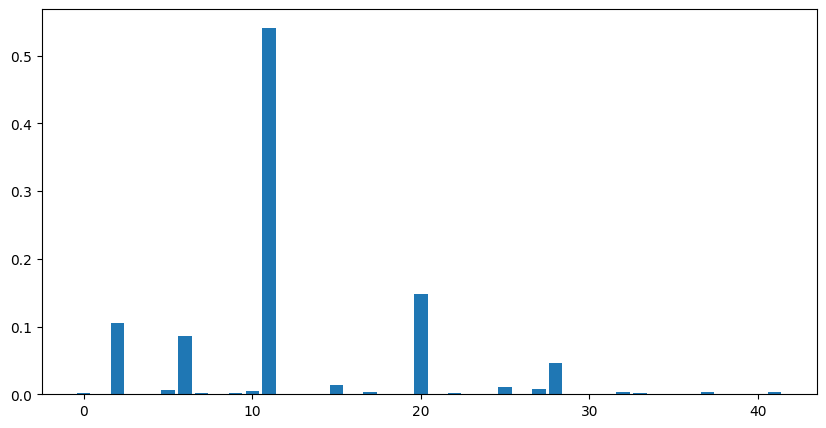

In [29]:
import torch.functional as F
with torch.no_grad():
    l = nn.Softmax()(model(test_dataset[432][0][0].view([1, 3, 224, 224])) * 0.5 + \
                     model(test_dataset[432][0][1].view([1, 3, 224, 224])) * 0.5)[0].cpu().numpy()

plt.figure(figsize=(10, 5))
plt.bar(x=range(42), height=l)

In [30]:
l[2], l[11]

(0.10593451, 0.54136795)

In [31]:
idx_to_class

{0: 'abraham_grampa_simpson',
 1: 'agnes_skinner',
 2: 'apu_nahasapeemapetilon',
 3: 'barney_gumble',
 4: 'bart_simpson',
 5: 'carl_carlson',
 6: 'charles_montgomery_burns',
 7: 'chief_wiggum',
 8: 'cletus_spuckler',
 9: 'comic_book_guy',
 10: 'disco_stu',
 11: 'edna_krabappel',
 12: 'fat_tony',
 13: 'gil',
 14: 'groundskeeper_willie',
 15: 'homer_simpson',
 16: 'kent_brockman',
 17: 'krusty_the_clown',
 18: 'lenny_leonard',
 19: 'lionel_hutz',
 20: 'lisa_simpson',
 21: 'maggie_simpson',
 22: 'marge_simpson',
 23: 'martin_prince',
 24: 'mayor_quimby',
 25: 'milhouse_van_houten',
 26: 'miss_hoover',
 27: 'moe_szyslak',
 28: 'ned_flanders',
 29: 'nelson_muntz',
 30: 'otto_mann',
 31: 'patty_bouvier',
 32: 'principal_skinner',
 33: 'professor_john_frink',
 34: 'rainier_wolfcastle',
 35: 'ralph_wiggum',
 36: 'selma_bouvier',
 37: 'sideshow_bob',
 38: 'sideshow_mel',
 39: 'snake_jailbird',
 40: 'troy_mcclure',
 41: 'waylon_smithers'}

In [32]:
trues = pd.read_csv('best_submission.csv').sort_values(by='Id').reset_index(drop=True)
trues.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [33]:
my_submit = my_submit.sort_values(by='Id').reset_index(drop=True)
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [34]:
(my_submit['Expected'] == trues['Expected']).sum(), (my_submit['Expected'] == trues['Expected']).count()

(991, 991)

In [35]:
my_submit[my_submit['Expected'] != trues['Expected']]

,Id,Expected


In [36]:
trues[my_submit['Expected'] != trues['Expected']]

,Id,Expected


In [37]:
mask = np.random.rand(len(my_submit)) < 0.19
mask[432] = 1
f1s = f1_score(trues.loc[mask, 'Expected'], my_submit.loc[mask, 'Expected'], average='micro')
f1s, (f1s - 0.8) * 500

(1.0, 99.99999999999997)